In [1]:
%%capture
%pip install datasets
%pip install transformers
%pip install torch
%pip install matplotlib
%pip install pillow
%pip install torchvision

In [2]:
import os
from datasets import Dataset, concatenate_datasets
from transformers import AutoImageProcessor, ResNetForImageClassification
from torchvision import transforms, datasets
from torch.utils.data import DataLoader, random_split
import torch
import torch.nn as nn
import torch.optim as optim
import PIL
import matplotlib.pyplot as plt
from tqdm import tqdm

/Library/Frameworks/Python.framework/Versions/3.12/lib/python3.12/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [7]:
# Directories for damage and no-damage images
original_dataset_dir = ''
train_damage_dir = os.path.join(original_dataset_dir, 'damage')
train_nodamage_dir = os.path.join(original_dataset_dir, 'no_damage')

# Load the pre-trained ResNet model and processor
train_dir = 'train_another'  # Path to training data
validation_dir = 'validation_another'  # Path to validation data
transform = transforms.Compose([
    transforms.Resize((150, 150)),  # Resize to match target_size from Keras example
    transforms.ToTensor(),
    transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225])  # Normalize to match pre-trained ResNet
])

# Load training and validation datasets
train_dataset = datasets.ImageFolder(train_dir, transform=transform)
validation_dataset = datasets.ImageFolder(validation_dir, transform=transform)

# Create data loaders for training and validation
train_loader = DataLoader(train_dataset, batch_size=20, shuffle=True)
validation_loader = DataLoader(validation_dataset, batch_size=20, shuffle=False)


In [12]:
processor = AutoImageProcessor.from_pretrained("microsoft/resnet-50")
model = ResNetForImageClassification.from_pretrained("microsoft/resnet-50")

in_features = model.classifier[-1].in_features  # Access the last Linear layer directly

# Modify the model's classification head for binary classification
model.classifier = nn.Sequential(
    nn.Flatten(),  # Ensure output is flattened if necessary
    nn.Linear(in_features, 10),  # Replace with a single output
    nn.ReLU(),
    nn.Linear(10,1),
    nn.Sigmoid()  # A
)

# Ensure the model is in evaluation mode
model.eval()

# Define a function to load, preprocess, and predict image categories using ResNet

ResNetForImageClassification(
  (resnet): ResNetModel(
    (embedder): ResNetEmbeddings(
      (embedder): ResNetConvLayer(
        (convolution): Conv2d(3, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False)
        (normalization): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
        (activation): ReLU()
      )
      (pooler): MaxPool2d(kernel_size=3, stride=2, padding=1, dilation=1, ceil_mode=False)
    )
    (encoder): ResNetEncoder(
      (stages): ModuleList(
        (0): ResNetStage(
          (layers): Sequential(
            (0): ResNetBottleNeckLayer(
              (shortcut): ResNetShortCut(
                (convolution): Conv2d(64, 256, kernel_size=(1, 1), stride=(1, 1), bias=False)
                (normalization): BatchNorm2d(256, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
              )
              (layer): Sequential(
                (0): ResNetConvLayer(
                  (convolution): Conv2d(64

In [13]:
from torch import nn, optim

# Define the device
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

# Freeze earlier layers
for param in model.parameters():
    param.requires_grad = False

# Ensure the classification layers are trainable
for param in model.classifier.parameters():
    param.requires_grad = True

# Define the optimizer (only for trainable parameters)
optimizer = optim.Adam(filter(lambda p: p.requires_grad, model.parameters()), lr=1e-4)

# Define the loss function
criterion = nn.BCELoss()  # Or nn.BCEWithLogitsLoss if you remove the final Sigmoid


In [14]:
for name, param in model.named_parameters():
    print(f"{name} - requires_grad: {param.requires_grad}")

resnet.embedder.embedder.convolution.weight - requires_grad: False
resnet.embedder.embedder.normalization.weight - requires_grad: False
resnet.embedder.embedder.normalization.bias - requires_grad: False
resnet.encoder.stages.0.layers.0.shortcut.convolution.weight - requires_grad: False
resnet.encoder.stages.0.layers.0.shortcut.normalization.weight - requires_grad: False
resnet.encoder.stages.0.layers.0.shortcut.normalization.bias - requires_grad: False
resnet.encoder.stages.0.layers.0.layer.0.convolution.weight - requires_grad: False
resnet.encoder.stages.0.layers.0.layer.0.normalization.weight - requires_grad: False
resnet.encoder.stages.0.layers.0.layer.0.normalization.bias - requires_grad: False
resnet.encoder.stages.0.layers.0.layer.1.convolution.weight - requires_grad: False
resnet.encoder.stages.0.layers.0.layer.1.normalization.weight - requires_grad: False
resnet.encoder.stages.0.layers.0.layer.1.normalization.bias - requires_grad: False
resnet.encoder.stages.0.layers.0.layer.2.

In [15]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
model.to(device)

criterion = nn.BCELoss()
optimizer = optim.Adam(model.parameters(), lr=0.001)

# Training loop
epochs = 5  # Adjust as needed
print("Start training")
for epoch in tqdm(range(epochs)):
    model.train()
    running_loss = 0.0
    for inputs, labels in tqdm(train_loader):
        # Convert labels to match the output format
        labels = labels.unsqueeze(1).float()
        inputs, labels = inputs.to(device), labels.to(device)
        
        # Zero the parameter gradients
        optimizer.zero_grad()
        
        # Forward pass
        outputs = model(inputs).logits
        loss = criterion(outputs, labels)
        
        # Backward pass and optimize
        loss.backward()
        optimizer.step()
        
        # Track loss
        running_loss += loss.item()

    # Print epoch loss
    print(f"Epoch [{epoch + 1}/{epochs}], Loss: {running_loss / len(train_loader):.4f}")

print("Training complete.")


Start training


 20%|██        | 1/5 [14:54<59:39, 894.99s/it]

Epoch [1/5], Loss: 0.3864


 40%|████      | 2/5 [29:10<43:34, 871.66s/it]

Epoch [2/5], Loss: 0.2605


 60%|██████    | 3/5 [58:06<42:12, 1266.22s/it]

Epoch [3/5], Loss: 0.2413


 80%|████████  | 4/5 [1:13:21<18:47, 1127.71s/it]

Epoch [4/5], Loss: 0.2100


100%|██████████| 5/5 [11:07:22<00:00, 8008.51s/it] 

Epoch [5/5], Loss: 0.2057
Training complete.


In [16]:
torch.save(model.state_dict(), 'resnetmodel.pth')

In [17]:
def predict_image_category(image_path):
    # Load image using PIL
    image = PIL.Image.open(image_path)
    # Preprocess image
    inputs = processor(image, return_tensors="pt")
    # Run the model to get predictions
    with torch.no_grad():
        logits = model(**inputs).logits
    # Apply threshold for binary classification (e.g., 0.5)
    predicted_label = (logits.sigmoid() > 0.5).item()
    return 'Damage' if predicted_label else 'No Damage'

# Test on a few sample images from the dataset



# Optionally, visualize the predictions




In [18]:
sample_damage_image_path = os.path.join(train_damage_dir, os.listdir(train_damage_dir)[2])
sample_nodamage_image_path = os.path.join(train_nodamage_dir, os.listdir(train_nodamage_dir)[2])

In [20]:
print("Predicted label for a damage image:", predict_image_category(sample_damage_image_path))
print("Predicted label for a no-damage image:", predict_image_category(sample_nodamage_image_path))

Predicted label for a damage image: Damage
Predicted label for a no-damage image: Damage


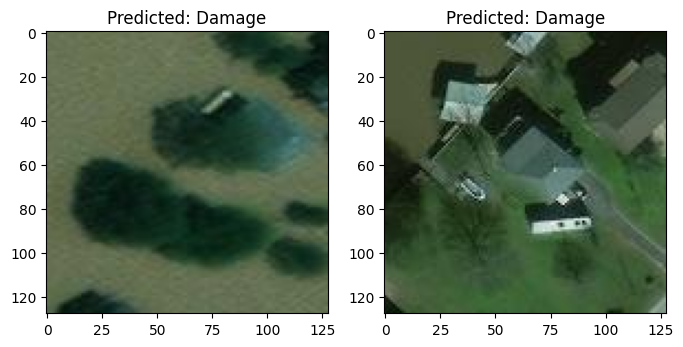

In [21]:
image_damage = PIL.Image.open(sample_damage_image_path)
image_nodamage = PIL.Image.open(sample_nodamage_image_path)
plt.figure(figsize=(8, 4))
plt.subplot(1, 2, 1)
plt.imshow(image_damage)
plt.title(f"Predicted: {predict_image_category(sample_damage_image_path)}")

plt.subplot(1, 2, 2)
plt.imshow(image_nodamage)
plt.title(f"Predicted: {predict_image_category(sample_nodamage_image_path)}")

plt.show()


## Evaluate model

In [62]:
test_dir = 'test_another'  # Path to test data
test_dataset = datasets.ImageFolder(test_dir, transform=transform)

# Create a data loader for the test dataset
test_loader = DataLoader(test_dataset, batch_size=20, shuffle=False)


In [63]:
def test(model):
    model.eval()
    test_loss = 0
    correct = 0
    
    # Use BCEWithLogitsLoss for binary classification
    criterion = torch.nn.BCEWithLogitsLoss()

    with torch.no_grad():
        for data, target in tqdm(test_loader):
            # Move data and target to the device
            data, target = data.to(device), target.to(device).float()  # Ensure target is float for BCEWithLogitsLoss
            
            # Get model predictions
            output = model(data)

            # Extract logits from model output if it's a custom object
            if isinstance(output, dict):
                logits = output["logits"]
            elif hasattr(output, "logits"):
                logits = output.logits
            else:
                logits = output  # Assuming it's a plain tensor

            # Calculate loss
            test_loss += criterion(logits.squeeze(), target).item()  # Sum up batch loss
            
            # Binary predictions (threshold at 0.5)
            pred = (torch.sigmoid(logits.squeeze()) > 0.5).long()
            correct += pred.eq(target.long()).sum().item()

    # Average loss
    test_loss /= len(test_loader.dataset)

    # Accuracy calculation
    accuracy = 100. * correct / len(test_loader.dataset)
    print('\nTest set: Average loss: {:.4f}, Accuracy: {}/{} ({:.0f}%)\n'.format(
        test_loss, correct, len(test_loader.dataset), accuracy))
    
    return test_loss, accuracy


In [64]:
test(model)

100%|██████████| 450/450 [14:10<00:00,  1.89s/it]


Test set: Average loss: 0.0370, Accuracy: 1000/9000 (11%)



(0.036984557174974016, 11.11111111111111)

In [68]:
print(len(test_loader))

450
